In [ ]:
### Tex downloads for colab. Ignore if on local
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
!pip install latex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
class SHE():
    def __init__(self, N = 100, g  =1 , u = 0.25 , T = 0.5, CFL = 0.5 , flux = 'LF'):
        self.N = N
        self.g = g
        self.dx = 2/(N)
        self.k = None
        self.u = u
        self.bc = None
        h = np.zeros(N+1)
        m = np.zeros(N+1)
        self.q = np.array([h,m])
        self.x = np.linspace(0, 2, N+1)
        self.CFL = 0.5
        self.T = T
        self.t = 0
        self.h0 = None
        self.use_source = True
        if flux == 'LF':
          self.flux = self.F
        else:
          self.flux = self.FLW


    def update_k(self):
        """Time-step update"""
        u = self.q[1] / self.q[0]
        self.k = self.CFL * self.dx / (np.max(np.abs(u) + np.sqrt(self.g*self.q[0])))

    def update_N(self, N_new):
        """Setting new mesh discretization"""
        self.N = N_new
        self.dx = 2/N_new
        h = np.zeros(N_new+1)
        m = np.zeros(N_new+1)
        self.q = np.array([h,m])
        self.x = np.linspace(0, 2, N_new+1)

    def IV(self , h:callable , m:callable):
        """Setting the initial values with two functions h and m"""
        self.h0 = h
        self.q[0] = h(self.x)
        self.q[1] = m(self.x)

    def f(self , u):
        """Defining the flux term in the Shallow Water Equation"""
        return np.array([u[1], ((u[1]**2)/u[0]) + 0.5*self.g*(u[0]**2)])


    def F(self , u,v):
        """Defining the Lax-Friedrich flux"""
        return np.array(0.5 * (self.f(u) + self.f(v)) - 0.5*(self.dx / self.k)*(v - u))

    def FLW(self,u,v):
        """ Defining the Lax-Wendroff flux using the Jacobian"""

        return np.array(0.5*(self.f(u)+self.f(v)) - 0.5*(self.k/self.dx)*(self.Jf(0.5*(u+v))@(self.f(v)-self.f(u))))

    def Jf(self, u):
        """ Defining the Jacobian for the Lax-Wendroff flux"""
        Jf = np.ndarray((2,2))
        Jf[0,0] = 0
        Jf[0,1] = 1
        Jf[1,0] = (-1)*(u[1]**2)/(u[0]**2) + self.g*u[0]
        Jf[1,1] = 2*(u[1]/u[0])
        return Jf

    def S(self, x_val):
        """Defining the relevant source term for problem 1"""
        s1 = np.pi/2 * (self.u-1) * np.cos(np.pi*(x_val-self.t))
        s2 = np.pi/2 * np.cos(np.pi*(x_val-self.t)) * (-self.u+(self.u**2)+self.g*self.h0(x_val-self.t))
        #print(s1,s2)
        return np.array([s1, s2])

    def set_BC(self , bc):
        """Setting the boundary condition type (P or O)"""
        self.bc = bc

    def set_Source(self , us):
        """Boolean to set the source term"""
        self.use_source = us

    def Solve(self):

        """Implementing the solver for the Shallow Water Equation"""
        self.t=0
        # Periodic boundary conditions
        if self.bc=="P":
            while self.t < self.T:
                self.update_k()

                if self.t + self.k > self.T:
                    self.k = self.T - self.t #No need to overshoot, but could be left out as well.

                #Updating q
                q_old = self.q.copy()
                for j in range(self.N+1):
                    #Getting flux
                    flux_term = self.F(q_old[:,j] , q_old[:,(j+1) % self.N]) - self.F(q_old[:, (j-1) % self.N] , q_old[:,j])
                    # Applying equations
                    if(self.use_source):
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term + self.k * self.S(self.dx * j)
                    else:
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term

                self.t += self.k
        # Open boundary conditions
        elif self.bc=="O":
            while self.t < self.T:
                self.update_k()

                if self.t + self.k > self.T:
                    self.k = self.T - self.t

                self.t += self.k
                q_old = self.q.copy()
                for j in range(1 , self.N):
                    flux_term = self.flux(q_old[:,j] , q_old[:,(j+1)]) - self.flux(q_old[:, (j-1)] , q_old[:,j])

                    if(self.use_source):
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term + self.k * self.S(self.dx * j)
                    else:
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term


                self.q[:,0] = self.q[:,1]
                self.q[:,self.N] = self.q[:,self.N-1]
        else:
          print("No BC selected")
          exit()


In [11]:
### Implementing all the initial values:

#A
def h0_A(x):
    return 1 + 0.5*np.sin(np.pi * x)

def m0_A(x , u = 0.25):
    return u * h0_A(x)

#B
def h0_B(x):
    return 1 - 0.1*np.sin(np.pi * x)

def m0_B(x , u = 0.25):
    return 0


#C
def h0_C(x):
    return 1 - 0.2*np.sin(2 * np.pi * x)

def m0_C(x , u = 0.25):
    return 0.5

#D
def h0_D(x):
    return 1

def m0_D(x , u = 0.25):
    return np.piecewise(x, [x < 1, x>=1], [lambda x: -0.5, lambda x: 0])

In [12]:
def Convergence_analysis(final_time , N_initial , iterations , bc , h0, m0, h_ref, m_ref, exact=True, Source = True, flux = "LF"):
  # Define Problem
  N = N_initial
  Problem = SHE(T = final_time, N = N, flux = flux)

  # Set Bc
  Problem.set_BC(bc)
  if not Source:
    Problem.set_Source(False)

  #Set parameters
  h_error = np.zeros(iterations)
  m_error = np.zeros(iterations)
  dxs = np.zeros(iterations)

  for i in range(iterations):
    print(f"Doing test with N={N}")
    Problem.update_N(N)
    Problem.IV(h0 , m0)
    Problem.Solve()

    if exact:
      h_ex = h_exact(Problem.x , final_time)
      m_ex = m_exact(Problem.x , final_time)
    else:
      h_ex = h_ref[::2**(iterations - i +1)]
      m_ex = m_ref[::2**(iterations - i +1)]
    #print(h_ex.shape)

    h_num = Problem.q[0]
    m_num = Problem.q[1]

    h_error[i] = np.linalg.norm(h_num - h_ex, ord = 2) * Problem.dx
    m_error[i] = np.linalg.norm(m_num - m_ex, ord = 2) * Problem.dx
    dxs[i]     = Problem.dx
    #Frobenius[i] = np.linalg.norm(Problem.q - np.array([h_ex , m_ex]), ord="fro")
    N *= 2
  return Problem, h_error , m_error , dxs

## Problem 1

In [13]:
### Defining exact solutions
def h_exact(x , t) :
    #return 1 - 0.1*np.sin(np.pi*(x - t))
    return 1+ 0.5*np.sin(np.pi*(x - t))
def m_exact(x,t) :
    #return np.zeros_like(x)
    return 0.25 * h_exact(x , t)

In [14]:
# Performing convergence analysis and simulating a solution
final_time = 0.5
N = 40
bc = "P"
iterations = 8


Problem ,h_error , m_error, dxs = Convergence_analysis(final_time , N , iterations , bc , h0_A, m0_A, h_exact, m_exact)

Doing test with N=40
Doing test with N=80
Doing test with N=160
Doing test with N=320
Doing test with N=640
Doing test with N=1280


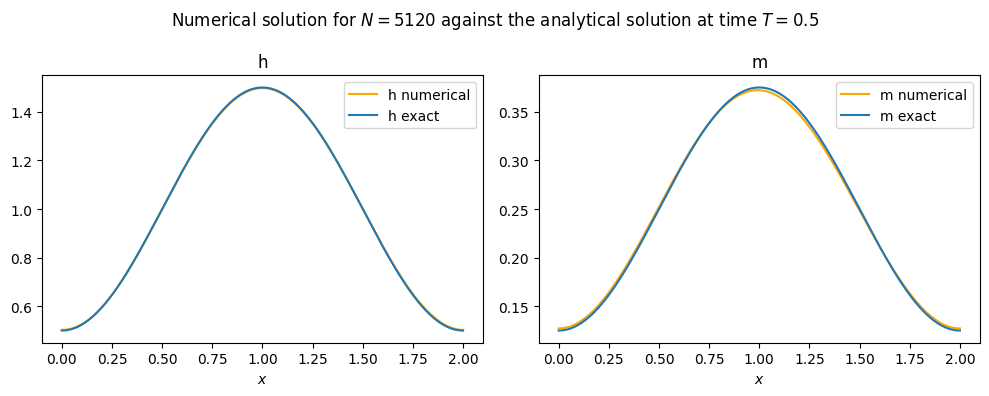

In [15]:
### Plotting numerical and exact solution
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Numerical solution for $N = 5120$ against the analytical solution at time $T = 0.5$")

x = Problem.x
h_sol = Problem.q[0]
m_sol = Problem.q[1]

# Plot data on the first subplot
axs[0].plot(x, h_sol, label='h numerical' , color = "orange")
axs[0].plot(x, h_exact(x , final_time), label='h exact')
axs[0].set_title('h')
axs[0].legend()
axs[0].set_xlabel('$x$')

# Plot data on the second subplot
axs[1].plot(x, m_sol, label='m numerical', color='orange')
axs[1].plot(x, m_exact(x , final_time), label='m exact')
axs[1].set_title('m')
axs[1].set_xlabel('$x$')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

#tikz.save('plots/1bcomparison.tex', figure=fig, standalone=True, encoding='utf-8') ### Many bugs with tikzplotlib, so don't use
# Show the plot
plt.show()

In [16]:
# Least squares error
logError = np.log(h_error+m_error)
logDx = np.log(dxs)

# Create a matrix with the independent variable (x)
A = np.vstack([logDx, np.ones(len(logDx))]).T

# Use numpy's least squares function to find the coefficients (m, c)
m, c = np.linalg.lstsq(A, logError, rcond=None)[0]
print(m,c)

1.4579415618741673 1.1988935598699983


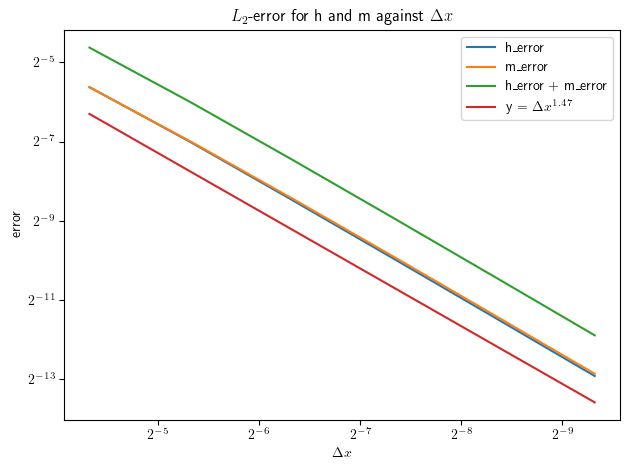

In [27]:
# Plotting convergence plots
plt.rcParams.update({
    "text.usetex": True,
})
plt.plot(dxs , h_error, label = "h_error")
plt.plot(dxs , m_error, label = "m_error")
plt.plot(dxs , h_error + m_error, label = "h_error + m_error")
plt.plot(dxs, dxs**(m), label ='y = $\Delta x^{1.47}$')
plt.xlabel('$\Delta x$')
plt.ylabel('error')
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.gca().invert_xaxis()
plt.legend()


plt.title(f'$L_2$-error for h and m against $\Delta x$')
plt.tight_layout()
#plt.savefig("plots/1berror.png")

# Show the plots
plt.show()

# Problem 2

In [26]:
# Define Problem
final_time = 0.5
N = 40
bc = "P"
iterations = 6

#Calculate reference solution for very fine mesh:
N_ref = N * 2**(iterations+1)

print(f"Calculating reference solution with N={N_ref} for case 2")
Ref2 = SHE(T = final_time , N = N_ref)
Ref2.set_BC("P")
Ref2.IV(h0_B , m0_B)
Ref2.set_Source(False)
x_ref2 = Ref2.x
Ref2.Solve()

h_ref2 = Ref2.q[0]
m_ref2 = Ref2.q[1]

Calculating reference solution with N=5120 for case 2


In [27]:
print(f"Calculating reference solution with N={N_ref} for case 3")
Ref3 = SHE(T = final_time , N = N_ref)
Ref3.set_BC("P")
Ref3.IV(h0_C , m0_C)
Ref3.set_Source(False)
x_ref3 = Ref3.x
Ref3.Solve()

h_ref3 = Ref3.q[0]
m_ref3 = Ref3.q[1]

Calculating reference solution with N=5120 for case 3


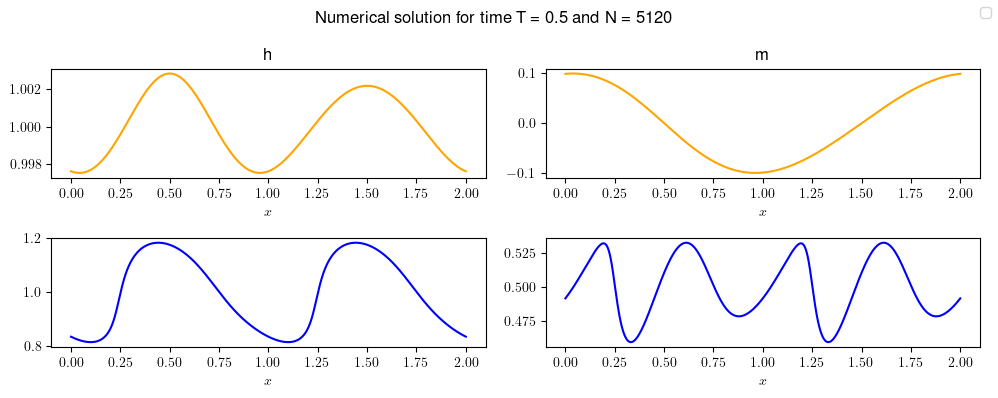

In [77]:
# Plotting numerical solutions for both initial values

fig, axs = plt.subplots(2, 2, figsize=(10, 4))

fig.suptitle(f"Numerical solution for time T = {final_time} and N = {N_ref}")

# Plot data on the first subplot
axs[0,0].plot(x_ref2, h_ref2, color="orange")
axs[1,0].plot(x_ref3, h_ref3, color="b")
axs[0,0].set_title('h')

# Plot data on the second subplot
axs[0,1].plot(x_ref2, m_ref2, color="orange")
axs[1,1].plot(x_ref3, m_ref3, color="b")
axs[0,1].set_title('m')

axs[0,0].set_xlabel("$x$")
axs[1,0].set_xlabel("$x$")
axs[1,1].set_xlabel("$x$")
axs[0,1].set_xlabel("$x$")

# Adjust layout to prevent clipping of titles
fig.legend()
fig.tight_layout()

# Show the plot
plt.show()

In [29]:
### Performing convergence analysis
Problem , h_error2, m_error2, dxs2 = Convergence_analysis(final_time , N , iterations , bc , h0_B, m0_B, h_ref2, m_ref2, exact=False, Source = False)
Problem , h_error3, m_error3, dxs3 = Convergence_analysis(final_time , N , iterations , bc , h0_B, m0_B, h_ref3, m_ref3, exact=False, Source = False)

Doing test with N=40
Doing test with N=80
Doing test with N=160
Doing test with N=320
Doing test with N=640
Doing test with N=1280
Doing test with N=40
Doing test with N=80
Doing test with N=160
Doing test with N=320
Doing test with N=640
Doing test with N=1280


In [32]:
### Performing least squares linear regression
logError2 = np.log(h_error2+m_error2)
logDx2 = np.log(dxs2)
A = np.vstack([logDx2, np.ones(len(logDx2))]).T

# Use numpy's least squares function to find the coefficients (m, c)
m2, c2 = np.linalg.lstsq(A, logError2, rcond=None)[0]
print(m2,c2)

logError3 = np.log(h_error3+m_error3)
logDx3 = np.log(dxs3)
A = np.vstack([logDx3, np.ones(len(logDx3))]).T

# Use numpy's least squares function to find the coefficients (m, c)
m3, c3 = np.linalg.lstsq(A, logError3, rcond=None)[0]
print(m3,c3)

1.5533790801532272 -0.6469144161329835
0.5023096728541374 -0.08449205230349406


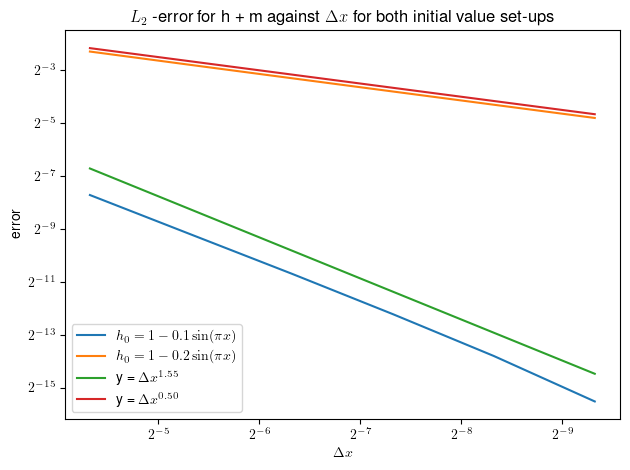

In [55]:
plt.rcParams.update({
    "text.usetex": True,
})
plt.plot(dxs2 , h_error2 + m_error2, label = '$h_0 = 1 − 0.1\sin (\pi x)$')
plt.plot(dxs3 , h_error3 + m_error3, label = '$h_0 = 1 − 0.2\sin (\pi x)$')


plt.plot(dxs2, dxs2**(m2), label = 'y = $\Delta x ^{1.55}$')
plt.plot(dxs2, dxs2**(m3), label = 'y = $\Delta x ^{0.50}$')

plt.xlabel('$\Delta x$')
plt.ylabel('error')
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.gca().invert_xaxis()
plt.legend()



plt.title(f'$L_2$ -error for h + m against $\Delta x$ for both initial value set-ups')
plt.tight_layout()
#plt.savefig("plots/1berror.png")

# Show the plots
plt.show()

## Problem 3

Doing test with N=50
Doing test with N=100
Doing test with N=200


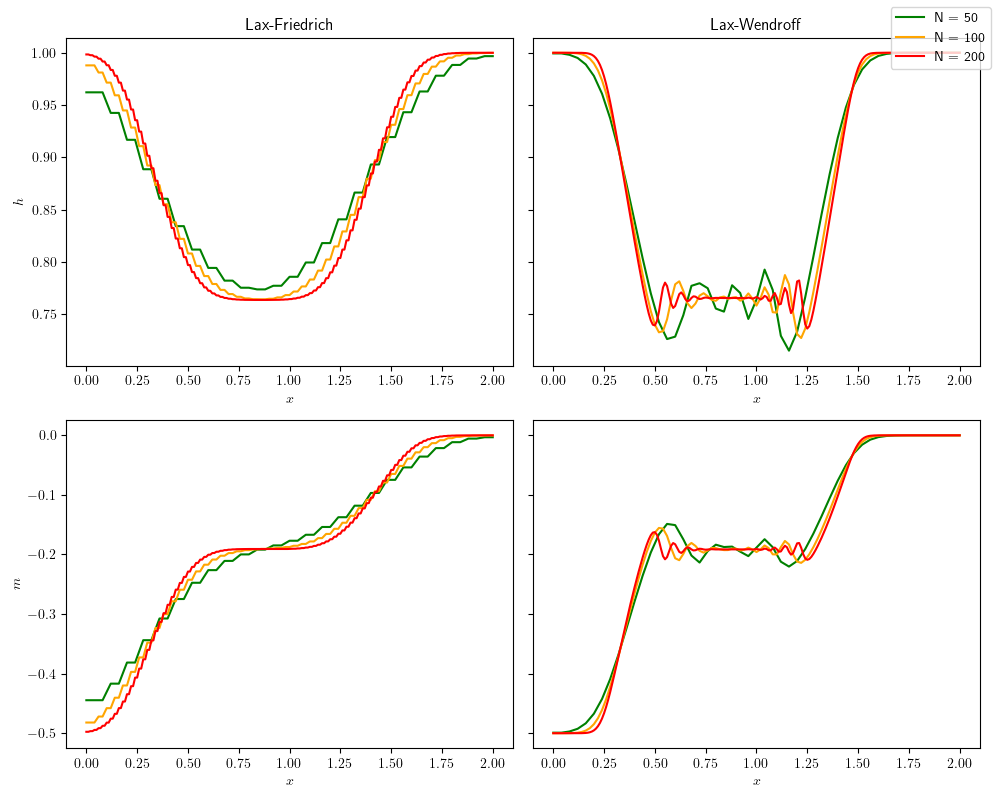

In [29]:
### Applying the scheme for both LW and LF flux, and plotting the result at different N-values
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey='row')
T_final = 0.5
N_start = 50
N = N_start

LF = SHE(T = T_final , N = N)
LW = SHE(T = T_final , N = N, flux = "LW")
LF.set_Source(False)
LW.set_Source(False)

LF.set_BC("O")
LW.set_BC("O")

LF.IV(h0_D , m0_D)
LW.IV(h0_D , m0_D)

iterations = 6
colors = ["green", "orange", "red", "blue", "purple", "pink", "black"]

h_relerror = np.zeros(iterations)
m_relerror = np.zeros(iterations)
dxs_rel = np.zeros(iterations)

for i in range(iterations):
  print(f"Doing test with N={N}")
  LF.update_N(N)
  LW.update_N(N)
  LF.IV(h0_D , m0_D)
  LW.IV(h0_D , m0_D)

  LF.Solve()
  LW.Solve()

  axs[0, 0].plot(LF.x, LF.q[0], color = colors[i], label=f'N = {N}')
  axs[0, 1].plot(LW.x, LW.q[0], color = colors[i])
  axs[0,0].set_title("Lax-Friedrich")
  axs[0,1].set_title("Lax-Wendroff")
  axs[0,0].set_ylabel("$h$")
  axs[1,0].set_ylabel("$m$")

  axs[1, 0].plot(LF.x, LF.q[1],color = colors[i])
  axs[1, 1].plot(LW.x, LW.q[1],color = colors[i])

  axs[0,0].set_xlabel("$x$")
  axs[1,0].set_xlabel("$x$")
  axs[1,1].set_xlabel("$x$")
  axs[0,1].set_xlabel("$x$")


  h_relerror[i] = np.linalg.norm(LF.q[0] - LW.q[0], ord = 2) * LF.dx
  m_relerror[i] = np.linalg.norm(LF.q[1] - LW.q[1], ord = 2) * LF.dx
  dxs_rel[i]     = LF.dx

  N*=2

# Adjust layout to prevent clipping of titles
fig.tight_layout()
fig.legend()

# Show the plot
plt.show()

In [97]:
### Calculating a reference LF scheme solution
# Define Problem
final_time = 0.5
N = 40
bc = "O"
iterations = 7

#Calculate reference solution for very fine mesh:
N_ref = N * 2**(iterations+1)

LF.update_N(N_ref)
LF.IV(h0_D , m0_D)
LF.Solve()
h_ref_LF = LF.q[0]
m_ref_LF = LF.q[1]

In [98]:
### Performing convergence analysis for LW scheme against our fine LF reference
Problem_LW , h_error_LW, m_error_LW, dxs_LW = Convergence_analysis(final_time , N , iterations , bc , h0_D, m0_D, h_ref_LF, m_ref_LF, exact=False, Source = False, flux = "LW")

Doing test with N=40
Doing test with N=80
Doing test with N=160
Doing test with N=320
Doing test with N=640
Doing test with N=1280
Doing test with N=2560


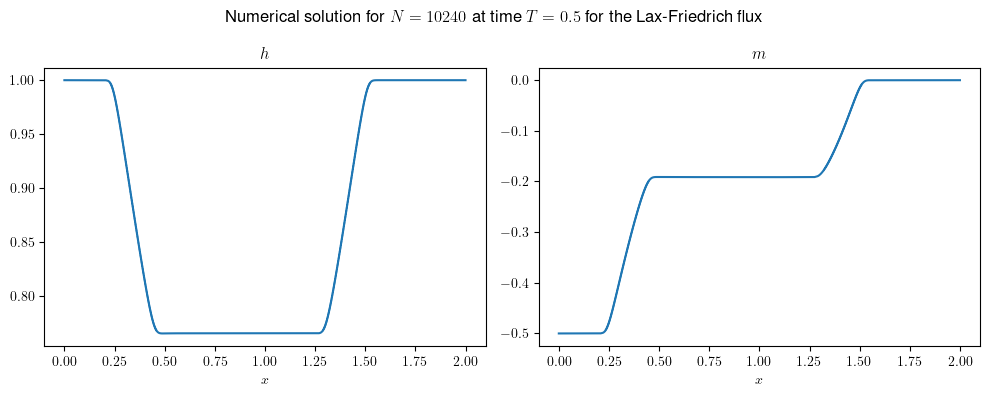

In [100]:
#Plotting reference solution

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f"Numerical solution for $N = {N_ref}$ at time $T = 0.5$ for the Lax-Friedrich flux")

x = LF.x
h_LF = LF.q[0]
m_LF = LF.q[1]

# Plot data on the first subplot
axs[0].plot(x, h_LF)
axs[0].set_title('$h$')
axs[0].set_xlabel('$x$')

# Plot data on the second subplot
axs[1].plot(x, m_LF)
axs[1].set_title('$m$')
axs[1].set_xlabel('$x$')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

#tikz.save('plots/1bcomparison.tex', figure=fig, standalone=True, encoding='utf-8')
# Show the plot
plt.show()

In [30]:
#Plotting convergence
plt.rcParams.update({
    "text.usetex": True,
})
plt.plot(dxs_LW , h_error_LW, label = '$h$')
plt.plot(dxs_LW , m_error_LW, label = '$m$')

plt.xlabel('$\Delta x$')
plt.ylabel('error')
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.gca().invert_xaxis()
plt.legend()



plt.title(f'$L_2$ -convergence for h and m for the Lax-Wendroff scheme against the reference Lax-Friedrich solution against $\Delta x$')
plt.tight_layout()
#plt.savefig("plots/1berror.png")

# Show the plots
plt.show()

NameError: ignored

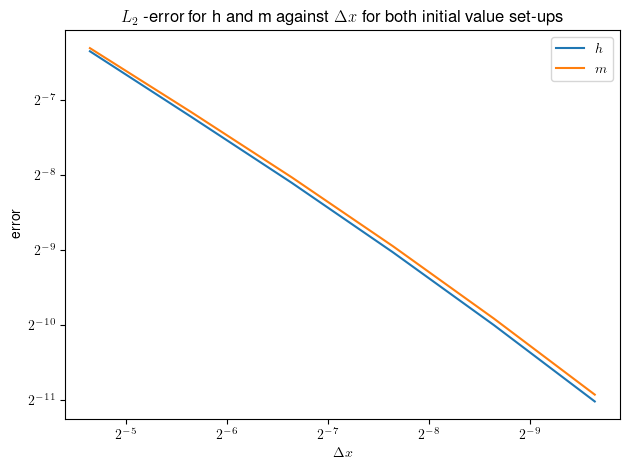

In [81]:
### LF and LW behave similarly: Alternative convergence analysis by comparing LF and LW at the same mesh size
plt.rcParams.update({
    "text.usetex": True,
})
plt.plot(dxs , h_relerror, label = '$h$')
plt.plot(dxs , m_relerror, label = '$m$')

plt.xlabel('$\Delta x$')
plt.ylabel('error')
plt.xscale("log", base=2)
plt.yscale("log", base=2)
plt.gca().invert_xaxis()
plt.legend()



plt.title(f'$L_2$ -error for h and m between the Lax-Friedrich and Lax-Wendroff numerical schemes for each $\Delta x$')
plt.tight_layout()
#plt.savefig("plots/1berror.png")

# Show the plots
plt.show()

